# MNIST — TensorFlow/Keras *Hello World*

This notebook trains a tiny CNN on the MNIST dataset using **TensorFlow / Keras**.

**What it does**
- Loads MNIST (prefers `data/raw/mnist.npz` if present; otherwise uses Keras loader).
- Trains a small ConvNet for a few epochs.
- Evaluates test accuracy, prints a confusion matrix, and saves artifacts:
  - `results/models/mnist_cnn.keras`
  - `results/figures/mnist_confusion.png`
  - `results/tables/preds.csv`

> Folder layout assumed by your project tree.


In [59]:
# If you see import errors for TensorFlow, add one of these to your requirements and rebuild your container:
#   tensorflow==2.16.1            # (with GPU support where available)
#   # or CPU-only:
#   tensorflow-cpu==2.16.1
#
# Then restart the kernel.

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Try TensorFlow import early to fail-fast if it's missing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Optional tools
try:
    from sklearn.metrics import confusion_matrix
except Exception:
    confusion_matrix = None

print("TensorFlow:", tf.__version__)
print("Keras backend:", keras.backend.backend())


TensorFlow: 2.16.1
Keras backend: tensorflow


In [60]:
# Reproducibility & folders
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

ROOT = Path('.')
DATA_DIR = ROOT / '../data'
RAW = DATA_DIR / 'raw'
RESULTS = ROOT / '../results'
FIGS = RESULTS / 'figures'
MODELS = RESULTS / 'models'
TABLES = RESULTS / 'tables'

for p in [DATA_DIR, RAW, RESULTS, FIGS, MODELS, TABLES]:
    p.mkdir(parents=True, exist_ok=True)

print("Directories ready.")    


Directories ready.


In [61]:
# Data loading utility: prefer local file, else use Keras
# Local expected path: data/raw/mnist.npz
# If offline, download mnist.npz manually into data/raw and re-run.

def load_mnist_local_first():
    local = RAW / 'mnist.npz'
    if local.exists():
        with np.load(local, allow_pickle=True) as f:
            x_train, y_train = f['x_train'], f['y_train']
            x_test, y_test = f['x_test'], f['y_test']
        print(f"Loaded MNIST from {local} →",
              f"x_train:{x_train.shape} x_test:{x_test.shape}")
    else:
        print("Local data/raw/mnist.npz not found; using Keras loader (will download if not cached).")
        (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
        # Optionally cache to data/raw for next time
        np.savez_compressed(local, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
        print(f"Cached MNIST to {local}")
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist_local_first()

# Normalize and add channel dimension
x_train = (x_train.astype('float32') / 255.0)[..., np.newaxis]  # (N,28,28,1)
x_test  = (x_test.astype('float32')  / 255.0)[..., np.newaxis]

print("x_train:", x_train.shape, "x_test:", x_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Loaded MNIST from ../data/raw/mnist.npz → x_train:(60000, 28, 28) x_test:(10000, 28, 28)
x_train: (60000, 28, 28, 1) x_test: (10000, 28, 28, 1)
y_train: (60000,) y_test: (10000,)


In [62]:
# Model — a tiny CNN good enough for a quick demo
model = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,714 (221.54 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
# Train (keep epochs small for a quick 'hello world')
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=128,
    verbose=1
)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7973 - loss: 0.7197 - val_accuracy: 0.9778 - val_loss: 0.0820
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9715 - loss: 0.0930 - val_accuracy: 0.9848 - val_loss: 0.0567
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9812 - loss: 0.0625 - val_accuracy: 0.9867 - val_loss: 0.0518
Test accuracy: 0.9848 | Test loss: 0.0482


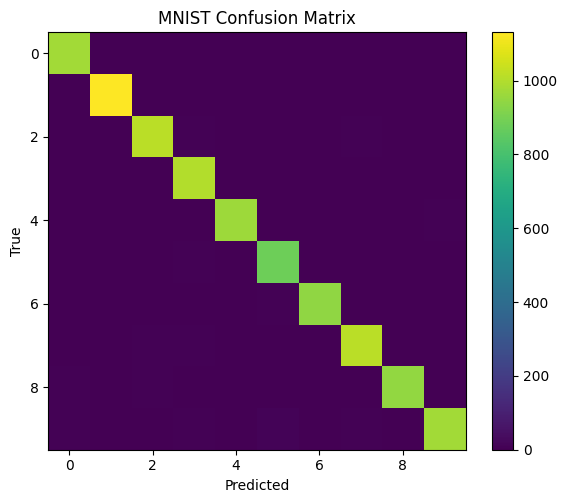

Saved confusion matrix → ../results/figures/mnist_confusion.png


In [64]:
# Predictions & confusion matrix
y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)

if confusion_matrix is not None:
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title('MNIST Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.tight_layout()
    fig_path = FIGS / 'mnist_confusion.png'
    plt.savefig(fig_path, dpi=150)
    plt.show()
    print(f"Saved confusion matrix → {fig_path}")
else:
    print("sklearn not available; skipping confusion matrix plot.")


In [65]:
# Save artifacts
model_path = MODELS / 'mnist_cnn.keras'
model.save(model_path)
print(f"Saved model → {model_path}")

# Save a small predictions CSV
import pandas as pd
sample_idx = np.arange(1000)
df = pd.DataFrame({
    'index': sample_idx,
    'true': y_test[sample_idx],
    'pred': y_pred[sample_idx]
})
csv_path = TABLES / 'preds.csv'
df.to_csv(csv_path, index=False)
print(f"Saved predictions sample → {csv_path}")

Saved model → ../results/models/mnist_cnn.keras
Saved predictions sample → ../results/tables/preds.csv


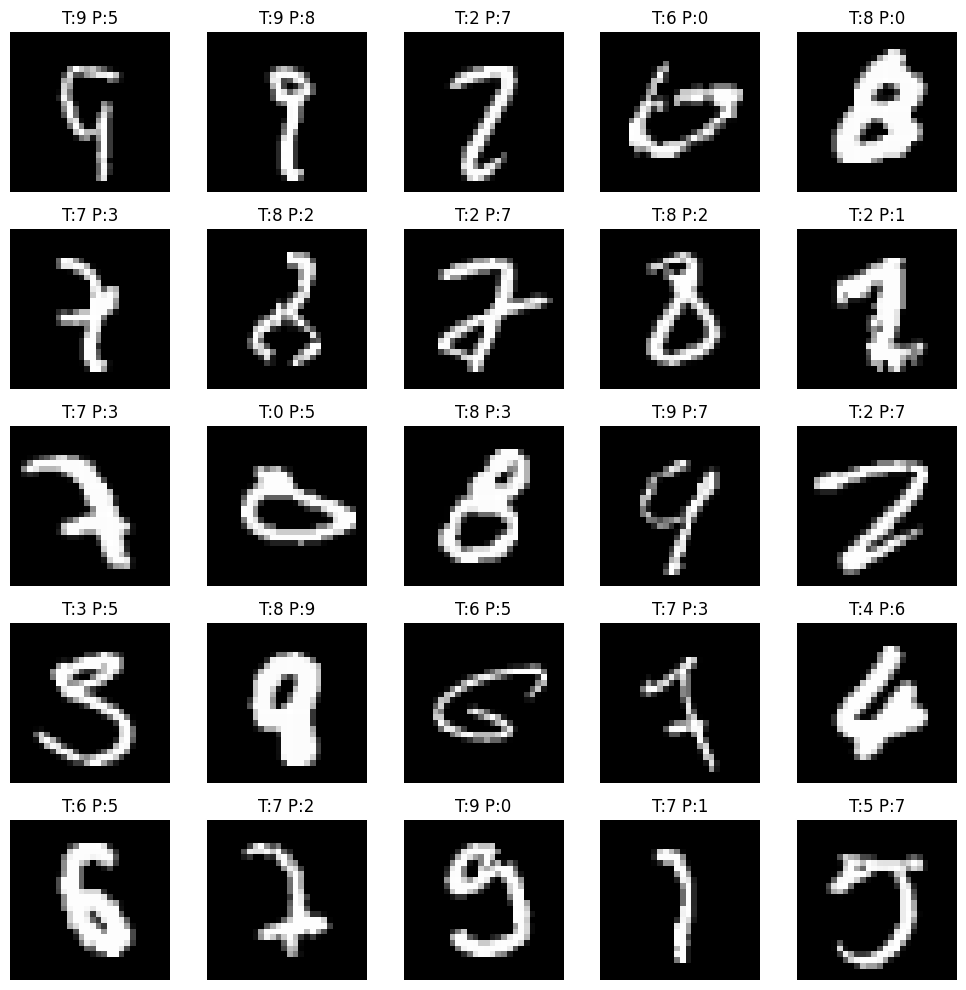

In [66]:
# Visualize some mistakes
mis = np.where(y_pred != y_test)[0][:25]
if mis.size > 0:
    cols = 5
    rows = int(np.ceil(len(mis)/cols))
    plt.figure(figsize=(10, 2*rows))
    for i, idx in enumerate(mis[:rows*cols]):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray')
        plt.title(f"T:{y_test[idx]} P:{y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications in the sampled subset (unusual but possible).")
